In [1]:
import sys, os
import pandas as pd
import networkx as nx
from shapely.geometry import Point, MultiPoint, LineString
print("Modules Imported")

from pyUtilslib import GetDistNet

# Define the directory with input files
workpath = os.getcwd()
inppath = workpath + "/input/"

# Load the power distribution network
sub = 150692
net = GetDistNet(inppath, sub)

# Convex hull for points in the network
pt_nodes = MultiPoint([Point(net.nodes[n]["cord"]) for n in net])
polygon = pt_nodes.convex_hull

# Load the fuel station data
df = pd.read_csv(inppath + "ev-stations.csv", 
                 usecols=["Longitude","Latitude"])
df = df.rename(columns={"Longitude":"x","Latitude":"y"})

# Find fuel stations within convex hull
net_fuel = [(df["x"][i],df["y"][i]) for i in range(len(df)) \
            if Point(df["x"][i],df["y"][i]).within(polygon)]

net_fuel = {"F"+str(i): f_cord for i,f_cord in enumerate(net_fuel)}
net_fuel

Modules Imported


{'F0': (-80.429844, 37.22983),
 'F1': (-80.432667, 37.234356),
 'F2': (-80.431354, 37.23173),
 'F3': (-80.434053, 37.232473)}

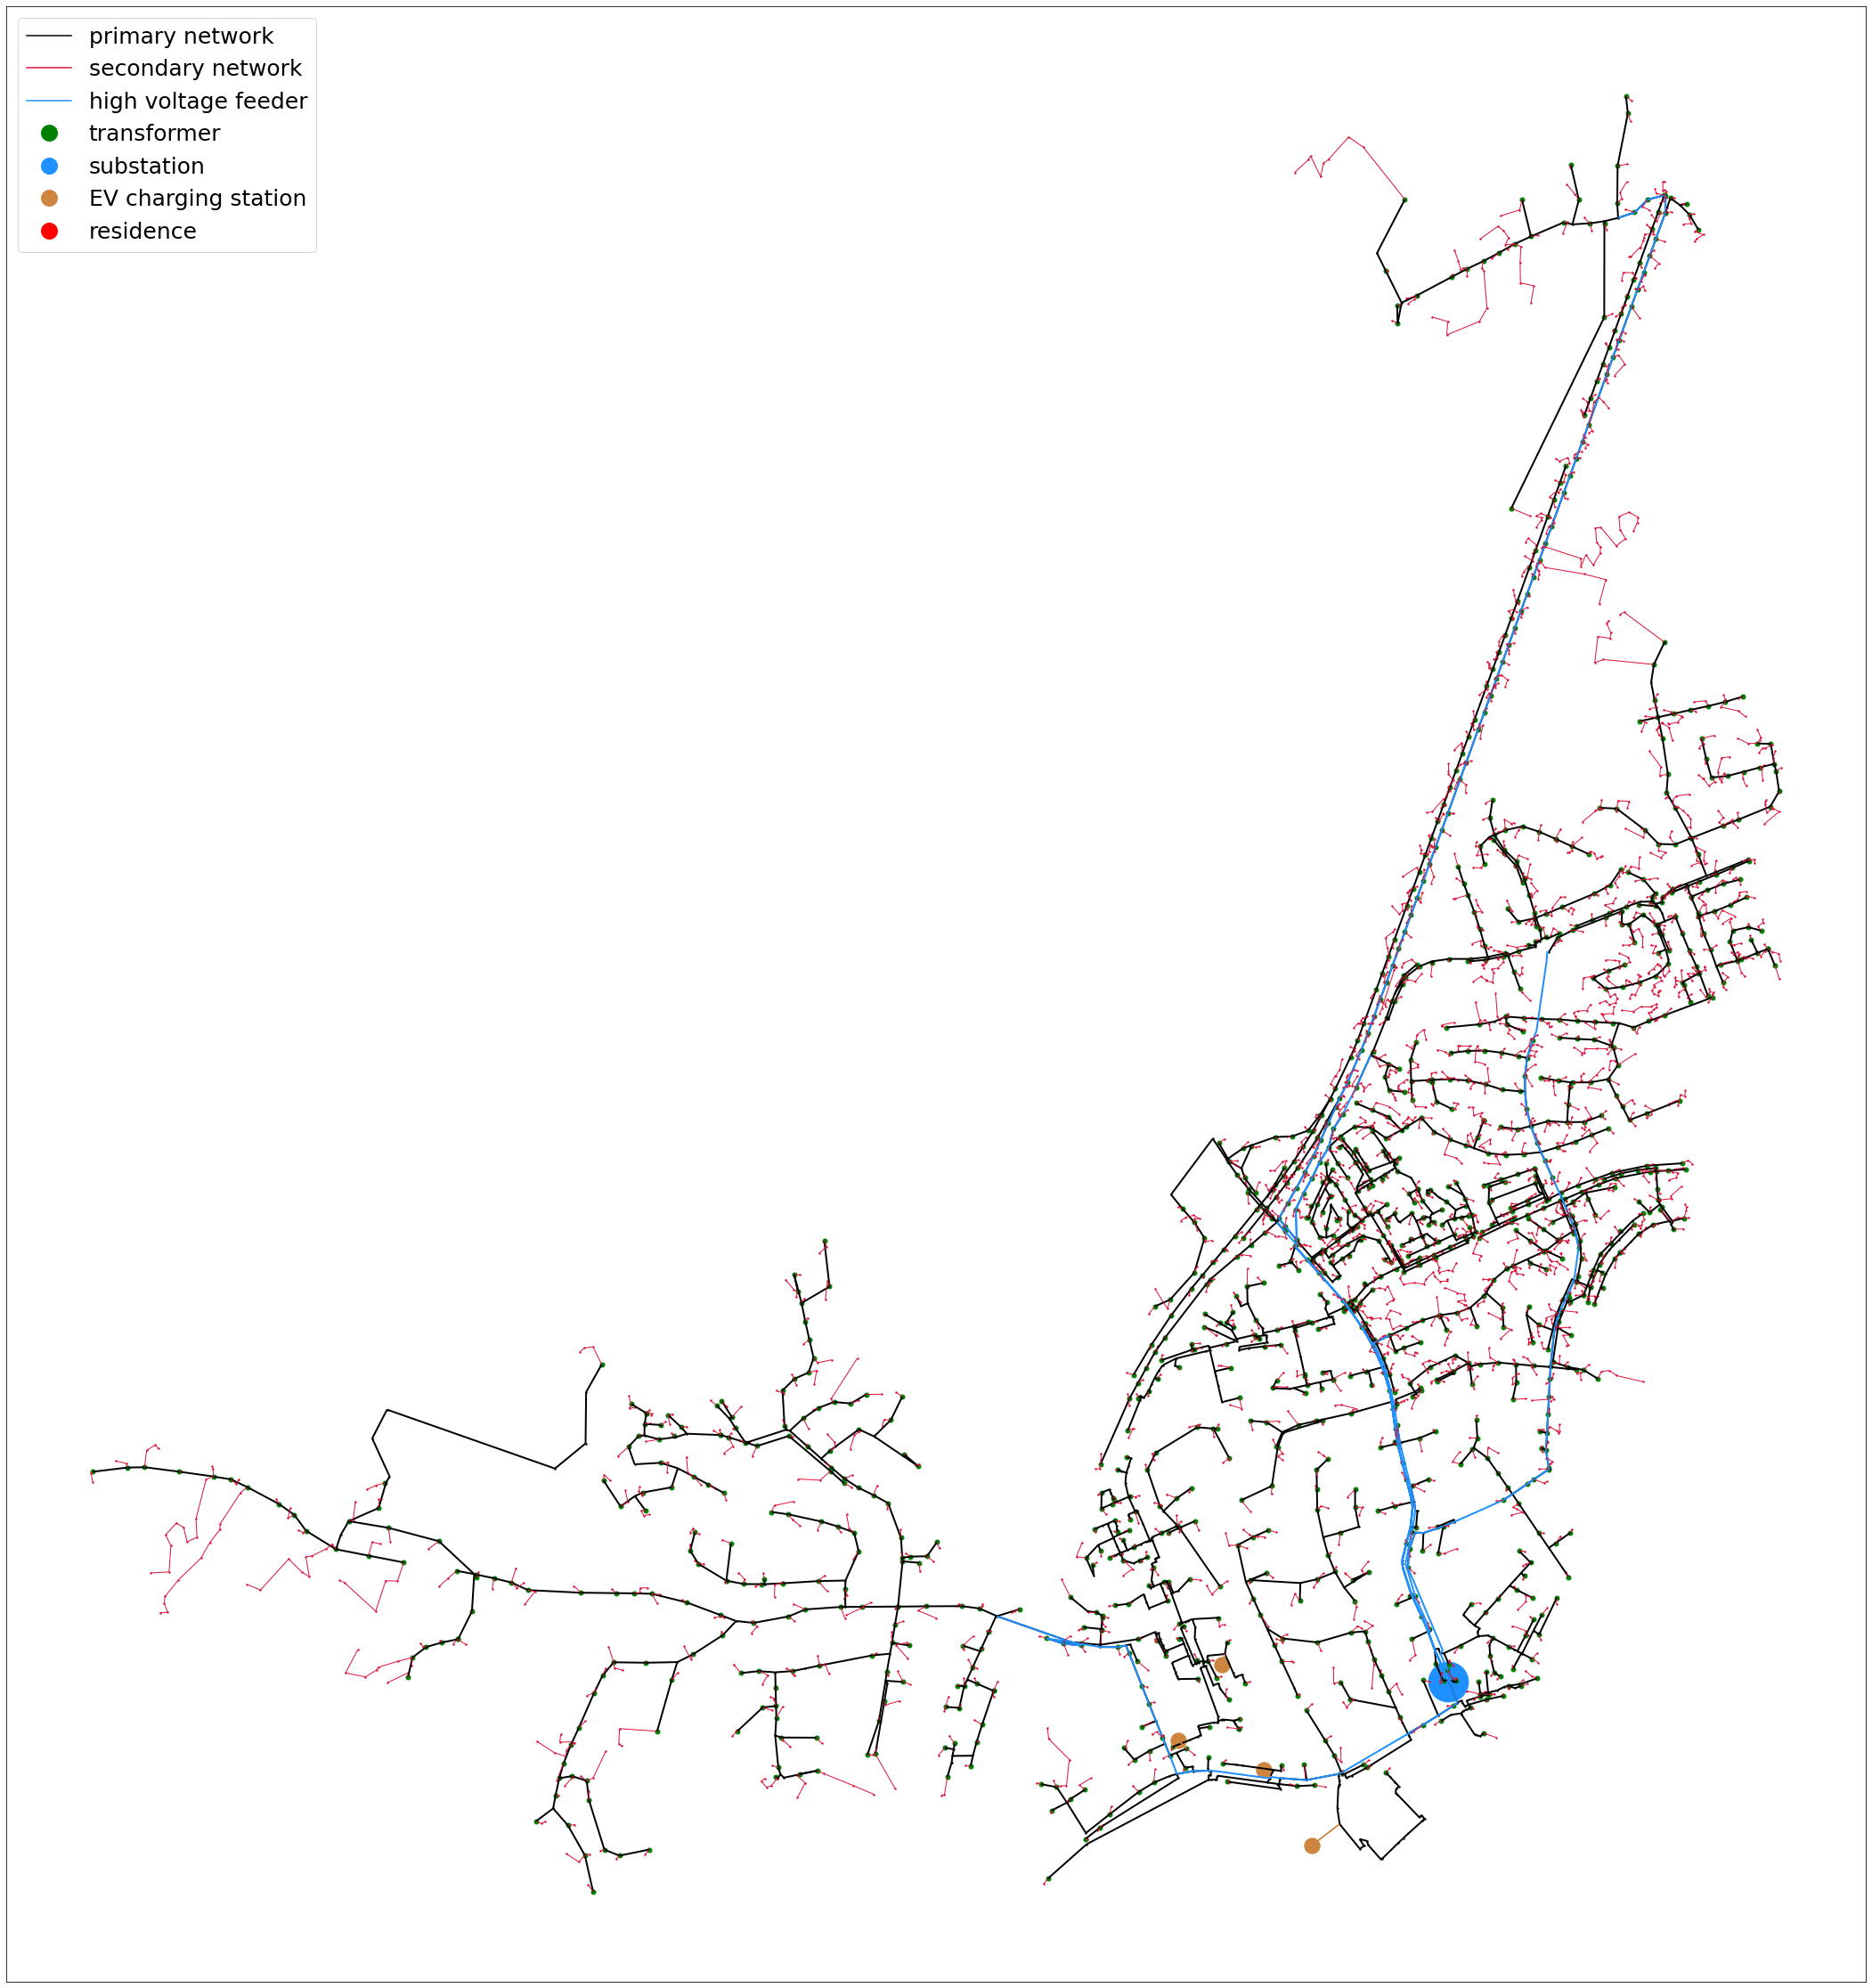

In [2]:
from pyUtilslib import plot_network, geodist

road_nodes = [n for n in net if net.nodes[n]['label']=='R']

for p_node,p in net_fuel.items():
    r_dist = {r:geodist(net.nodes[r]['cord'],p) for r in road_nodes}
    r_min = min(r_dist, key=r_dist.get)
    net.add_edge(r_min,p_node)
    net.nodes[p_node]["cord"] = p
    net.nodes[p_node]["label"] = "E"
    net.nodes[p_node]["load"] = 0.0
    
    net.edges[(r_min,p_node)]["label"] = "L"
    net.edges[(r_min,p_node)]["length"] = geodist(net.nodes[r_min]['cord'],p)
    net.edges[(r_min,p_node)]["r"] = 0.0822/363000 
    net.edges[(r_min,p_node)]["x"] = 0.0964/363000
    net.edges[(r_min,p_node)]["type"] = "OH_Penguin"
    net.edges[(r_min,p_node)]["geometry"] = LineString((net.nodes[r_min]['cord'],p))

    
plot_network(net)

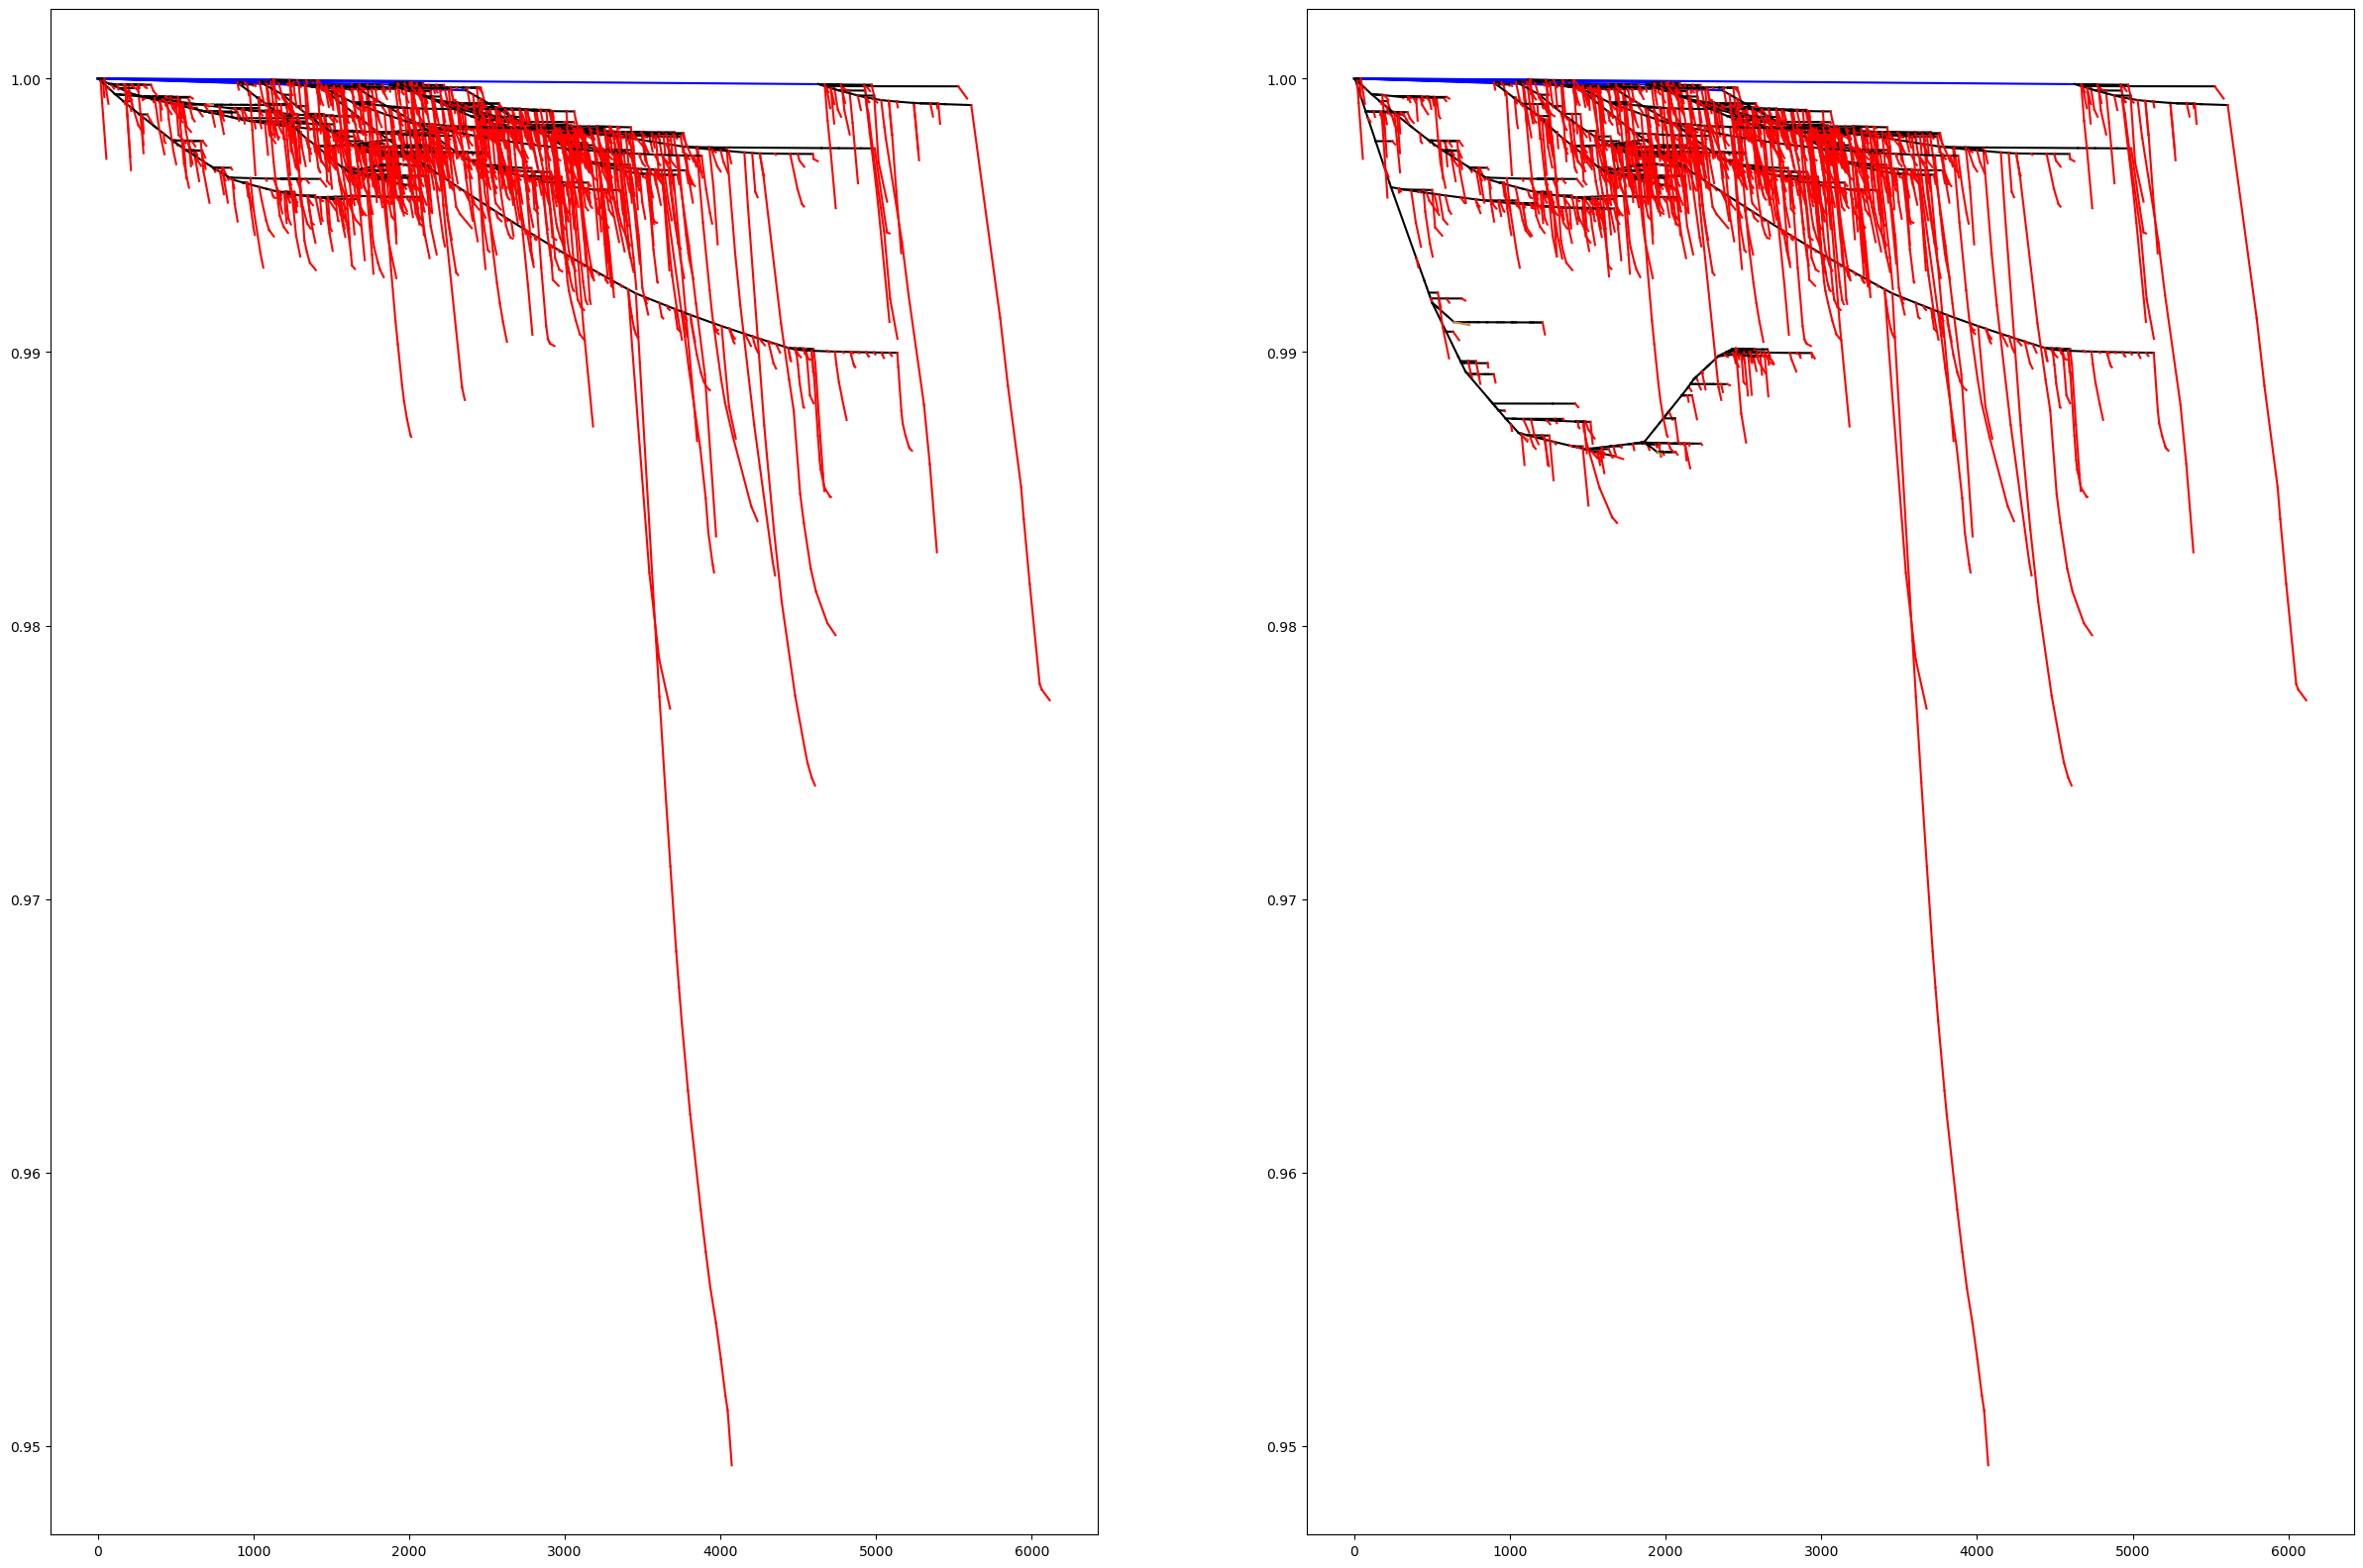

In [6]:
from pyUtilslib import powerflow
import matplotlib.pyplot as plt

d_nodes = {n:nx.shortest_path_length(net,n,sub,'length') for n in net}
color_ = {"E":"blue", "P":"black", "S":"red", "L":"peru"}

fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

total_load = sum([net.nodes[n]["load"] for n in net if net.nodes[n]["label"]=='H'])

p_EV = 0
for n in net_fuel:
    net.nodes[n]["load"] = p_EV

powerflow(net)
v_nodes = {n:net.nodes[n]["voltage"] for n in net}
for edge in net.edges:
    ax1.plot([d_nodes[edge[0]],d_nodes[edge[1]]],
             [v_nodes[edge[0]],v_nodes[edge[1]]],
             color=color_[net.edges[edge]["label"]])
    
factor = 0.4
p_EV = factor * total_load / len(net_fuel)
for n in net_fuel:
    net.nodes[n]["load"] = p_EV

powerflow(net)
v_nodes = {n:net.nodes[n]["voltage"] for n in net}
for edge in net.edges:
    ax2.plot([d_nodes[edge[0]],d_nodes[edge[1]]],
             [v_nodes[edge[0]],v_nodes[edge[1]]],
             color=color_[net.edges[edge]["label"]])

In [4]:
"F3" in net

True